In [1]:
from __future__ import (absolute_import, print_function, unicode_literals,
                        division)

import logging
logging.basicConfig(level=logging.DEBUG)

import joblib
import dropbot as db
import dropbot.chip
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.ticker
import numpy as np
import pandas as pd
import si_prefix as si

# %matplotlib inline

F_formatter = mpl.ticker.FuncFormatter(lambda x, *args: si.si_format(x) + 'F')

# Load Sci-Bots device file and extract neighbouring channels info.
svg_path = dropbot.DATA_DIR.joinpath('SCI-BOTS 90-pin array', 'device.svg')

# Used cached neighbours result (if available).  Otherwise, cache neighbours.
memcache = joblib.memory.Memory('.')
get_channel_neighbours = memcache.cache(db.chip.get_channel_neighbours)
neighbours = get_channel_neighbours(svg_path)

# Open DropBot connection

In [2]:
import base_node_rpc as bnr
import base_node_rpc.proxy

try:
    proxy.terminate()
except:
    pass
proxy = db.SerialProxy(ignore=[bnr.proxy.DeviceVersionMismatch])
proxy.neighbours = neighbours

proxy.enable_events()

proxy.update_state(hv_output_enabled=True, hv_output_selected=True,
                   voltage=100, frequency=10e3)

# Disable channels in contact with copper tape.
disabled_channels_mask_i = proxy.disabled_channels_mask
disabled_channels_mask_i[[89, 30]] = 1
proxy.disabled_channels_mask = disabled_channels_mask_i

DEBUG:trollius:Using selector: SelectSelector
DEBUG:base_node_rpc.async:`ProactorEventLoop` required, not `<class 'trollius.windows_events._WindowsSelectorEventLoop'>`loop in background thread.
DEBUG:base_node_rpc.async:Execute new loop in background thread.
DEBUG:trollius:Using proactor: IocpProactor
DEBUG:base_node_rpc.async:`ProactorEventLoop` required, not `<class 'trollius.windows_events._WindowsSelectorEventLoop'>`loop in background thread.
DEBUG:base_node_rpc.async:Execute new loop in background thread.
DEBUG:trollius:Using proactor: IocpProactor
DEBUG:base_node_rpc.proxy:Attempt to connect to device on port COM15 (baudrate=115200)
DEBUG:serial_device.threaded:Open `COM15` and monitor connection status
DEBUG:serial_device.threaded:connection_made: `COM15` `<ReaderThread(Thread-13, started daemon 8588)>`
DEBUG:base_node_rpc.proxy:Wait for connection to port COM15
INFO:base_node_rpc.proxy:Successfully connected to dropbot on port COM15


# Serial communication overhead

The `ram_free` method is nearly instant, so can be used to measure
communication overhead.

In [3]:
%timeit proxy.ram_free()

100 loops, best of 3: 6.78 ms per loop


# `channel_capacitances`

The `channel_capacitances` method performs:

 1. For each specified **channel**:
   1. **Set channel as only enabled bit** in `state_of_channels_`.
   2. **Update channels** by pushing new state to switching boards **(~5.5 ms)**
 2. **Restore original state** by pushing original channel states to switching boards **(~5.5 ms)**

The total time for each request is:

$T_{TOTAL} = T_{SERIAL} + T_{RESTORE} + kT_{CHANNEL}$ 

where:

$
\begin{array}{}
T_{SERIAL} &\approx 7~ms \\
T_{RESTORE} &\approx 5.5~ms \\
T_{CHANNEL} &\approx T_{RESTORE}
\end{array}
$

Note that $T_{CHANNEL}$ and $T_{RESTORE}$ are both dominated by the I2C communication time to the switching boards.

## Proposed performance improvements

 1. Reduce $T_{CHANNEL}$ and $T_{RESTORE}$ by **_only pushing updates to boards where channel states have changed_**.

additional time per channel: 5.5 ms                                                                 


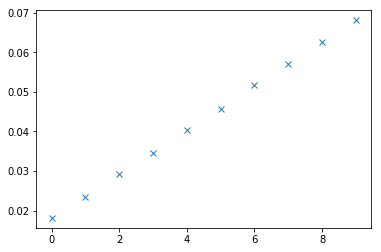

In [4]:
results = {}

for i in range(10):
    print('\rTesting {} channels...'.format(i + 1), end='')
    result_i = %timeit -q -o proxy.channel_capacitances(range(i + 1))
    results[i] = result_i
print('\r' + 100 * ' ' + '\r', end='')
s_results = pd.Series({k: r.best for k, r in results.items()})
s_results.plot(style='x')
print('additional time per channel: {}s'
      .format(si.si_format(s_results.diff().mean())))

# `channels::_update_channels`

The `channels::_update_channels` function can be benchmarked using the
`channels::_benchmark_channel_update` function through the`Node::_benchmark_channel_update` proxy API.

In [9]:
s_per_update = proxy._benchmark_channel_update(1000)
print('time per analog read: {}s'.format(si.si_format(s_per_update)))

time per analog read: 4.9 ms


Each execution of `_update_channels` takes **~5 ms**.

# `Node::benchmark_analog_read`

In [6]:
N = 1e3
duration = proxy.benchmark_analog_read(11, 1e3)
print('time per analog read: {}s'.format(si.si_format(duration / N)))

time per analog read: 16.7 µs


# `Node::benchmmark_u16_percentile_diff`

In [7]:
N = 1e3
n_samples = 50

duration = proxy.benchmmark_u16_percentile_diff(11, n_samples, 25, 75, N)
print('time per analog read: {}s'.format(si.si_format(duration / N
                                                      / n_samples)))

time per analog read: 19.0 µs


Text(0,0.5,u'measured capacitance')

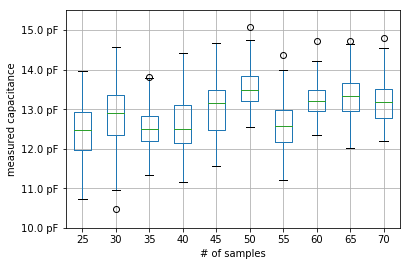

In [10]:
capacitances = pd.DataFrame()
original_n_samples = proxy.config.capacitance_n_samples

for capacitance_n_samples in range(25, 71, 5):
    proxy.update_config(capacitance_n_samples=capacitance_n_samples)
    capacitances_i = pd.Series(proxy.all_channel_capacitances(),
                               name='{}'.format(capacitance_n_samples)).sort_values().reset_index(drop=True)
    capacitances[capacitance_n_samples] = capacitances_i
proxy.update_config(capacitance_n_samples=original_n_samples)

axis = capacitances.boxplot()
axis.yaxis.set_major_formatter(F_formatter)
axis.set_ylim(10e-12, 15.5e-12)
axis.set_xlabel('# of samples')
axis.set_ylabel('measured capacitance')